# VC - Entrega P2

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [22]:
img = cv2.imread('mandril.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gris, 100, 200)

### 1 - Contar los bordes por filas y mostrar las filas con bordes por el encima de 90% del máximo

(0.0, 512.0)

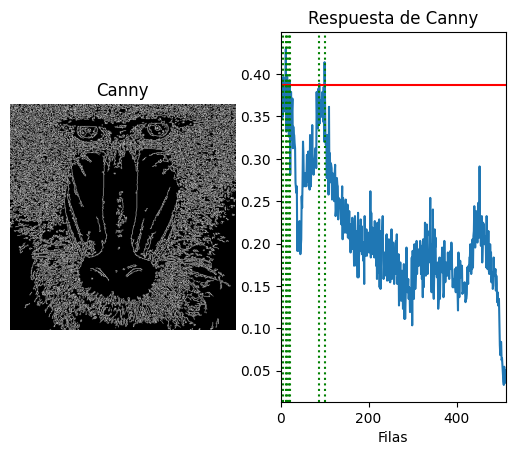

In [4]:
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
rows =[row_counts[i][0] / (255 * canny.shape[1]) for i in range(canny.shape[0])]

max_border_number = max(rows)

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("Filas")
plt.ylabel("% píxeles")
plt.plot(rows)
plt.axhline(y=max_border_number*0.9, color='r')

for i in range(len(rows)):
    if rows[i] > max_border_number*0.9:
        plt.axvline(x=i, color='g', linestyle=':')

plt.xlim([0, canny.shape[0]])



2. TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

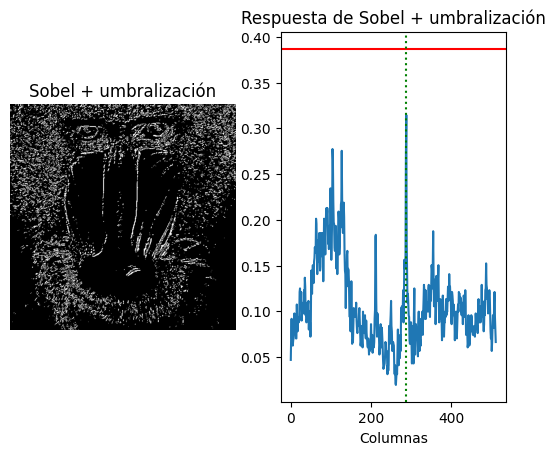

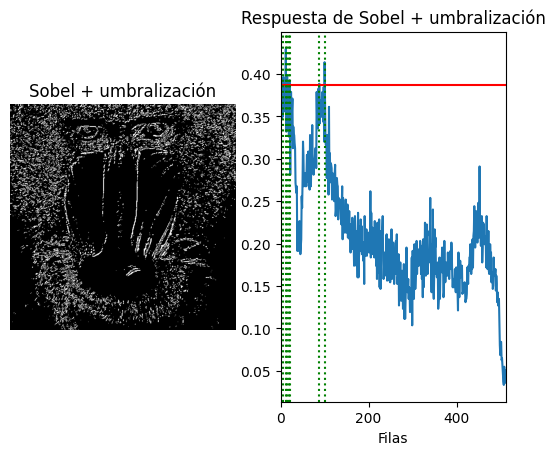

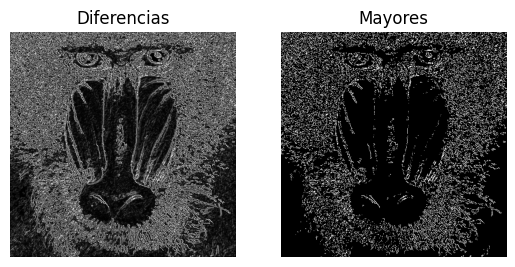

In [33]:
# Gaussiana para suavizar la imagen original, eliminando altas frecuencias
ggris = cv2.GaussianBlur(gris, (3, 3), 0)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gris, 100, 200)

#Calcula en ambas direcciones (horizontal y vertical)
sobelx = cv2.Sobel(ggris, cv2.CV_64F, 1, 0)  # x
sobely = cv2.Sobel(ggris, cv2.CV_64F, 0, 1)  # y
#Combina ambos resultados
sobel = cv2.add(sobelx, sobely)
sobel8np = np.uint8(np.abs(sobel))

#Umbralizamos la imagen de 8 bits del mandril
valorUmbral = 130
_, imagenUmbralizada8np = cv2.threshold(sobel8np, valorUmbral, 255, cv2.THRESH_BINARY)
#Conteo en columnas
col_counts = cv2.reduce(imagenUmbralizada8np,0,cv2.REDUCE_SUM,dtype=cv2.CV_32SC1)
cols = col_counts[0]/(255*imagenUmbralizada8np.shape[0])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Sobel + umbralización")
plt.imshow(imagenUmbralizada8np, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Respuesta de Sobel + umbralización")
plt.xlabel("Columnas")
plt.ylabel("% píxeles")
plt.plot(cols)
plt.axhline(y=max_border_number*0.9, color='r')
max_border_number = max(cols)
for i in range(len(cols)):
    if cols[i] > max_border_number*0.9:
        plt.axvline(x=i, color='g', linestyle=':')



row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
rows =[row_counts[i][0] / (255 * canny.shape[1]) for i in range(canny.shape[0])]
max_border_number = max(rows)



plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Sobel + umbralización")
plt.imshow(imagenUmbralizada8np, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Respuesta de Sobel + umbralización")
plt.xlabel("Filas")
plt.ylabel("% píxeles")
plt.plot(rows)
plt.axhline(y=max_border_number*0.9, color='r')

for i in range(len(rows)):
    if rows[i] > max_border_number*0.9:
        plt.axvline(x=i, color='g', linestyle=':')

plt.xlim([0, imagenUmbralizada8np.shape[0]])

dif = cv2.absdiff(canny,sobel8np)

#Visualiza
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Diferencias")
plt.axis("off")
plt.imshow(dif, cmap='gray') 

#Zonas de mayor diferencia tras aplicar umbral
res, imgdif = cv2.threshold(dif, 160, 255, cv2.THRESH_BINARY)
#Visualiza
plt.subplot(1, 2, 2)
plt.title("Mayores")
plt.axis("off")
plt.imshow(imgdif, cmap='gray') 
plt.show()



